<div style="display: flex; align-items: center; gap: 2px;">
  
  <div style="text-align: left; padding: 0;">
   <h2 style="font-size: 1.8em; margin-bottom: 0;"><b>Moving beyond Linearity...</b></h2>
   <br>
   <h3 style=" font-size: 1.2em;margin-bottom: 0;">Regression Splines</h3>
   <h3 style="font-size: 1.2em; margin-bottom: 0; color: blue;"><i>Dr. Satadisha Saha Bhowmick</i></h3>
  </div>

  <div style="margin-right: 5px; padding: 0;">
    <img src="images/intro-pic.png" align="right" alt="intro-pic" style="width: 70%;">
    <!-- TEXT NEXT TO IMAGE -->
      <div style="font-size: 0.5em;">
        <p>Woman teaching geometry, from a fourteenth-century edition of Euclid’s geometry book.</p>
      </div>
  </div>

</div>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
import ipywidgets as widgets
from IPython.display import display, clear_output
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.gam.api import BSplines

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

bac_data = pd.read_csv("BLOODALC.csv")

### Last Time

- We saw the limits of polynomials as a regression model.
- Also saw how poorly they fit some non linear functions.

Recall the $\color{blue}{\textbf{Runge function}}$ that we failed to fit well using higher order polynomials.

In [ ]:
np.random.seed(0)

# True nonlinear function (Runge function)
def runge(x):
    return 1 / (1 + 25 * x**2)

# Generate data
xg = np.linspace(-2, 2, 600)
yg_true = runge(xg)

degrees = [1, 3, 5, 9, 15, 20]
plt.figure(figsize=(9, 5))
plt.plot(xg, yg_true, linewidth=2, label="true f(x)")

for d in degrees:
    # Construct polynomial design matrix
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X = poly.fit_transform(xg.reshape(-1, 1))
    Xg = poly.transform(xg.reshape(-1, 1))
    
    # Fit least squares regression
    model = LinearRegression()
    model.fit(X, yg_true)
    
    # Predict on data
    yg_hat = model.predict(Xg)
    
    # Plot the fit
    plt.plot(xg, yg_hat, label=f"deg {d}")

plt.title("Limits of polynomial regression: Runge phenomenon")
plt.xlabel("X")
plt.ylabel("Y")
plt.xlim(-2.2, 2.2)
plt.legend()
# plt.show()

<img src="images/runge-polyfit.png" alt="Runge Phenomenon Polynomial Fit" scale="0.75;" style="width: 90%;">

$\color{blue}{\textbf{Big Idea}} \rightarrow$ While a single continuous polynomial cannot fit this function, what it we attempted to approximate parts of it using separate piecewise polynomials?

Here we approximate the runge function between $x = 0.5$ and $x=1$.

In [ ]:
np.random.seed(0)

# True nonlinear function (Runge function)
def runge(x):
    return 1 / (1 + 25 * x**2)

# Generate data
xg = np.linspace(0.5, 1, 10000)
yg_true = runge(xg)

degrees = [2,3]
plt.figure(figsize=(9, 5))
plt.scatter(xg, yg_true, linewidth=2, color="Gray", label="true f(x)")

for d in degrees:
    # Construct polynomial design matrix
    poly = PolynomialFeatures(degree=d, include_bias=False)
    X = poly.fit_transform(xg.reshape(-1, 1))
    Xg = poly.transform(xg.reshape(-1, 1))
    
    # Fit least squares regression
    model = LinearRegression()
    model.fit(X, yg_true)
    
    # Predict on data
    yg_hat = model.predict(Xg)
    
    # Plot the fit
    plt.plot(xg, yg_hat, label=f"deg {d}")

plt.title("Polynomial regression of Runge phenomenon")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


<img src="images/runge-polyfit-piecewise.png" alt="Piecewise Polynomial Fit (Runge)" scale="0.75;" style="width: 90%;">

### Splines

Splines regression is an application of this piecewise interpolation idea using a lower order polynomial (typically not more than third degree).

We simply approximate separate small segments of the overall regression using polynomials, connected smoothly at points called "<b>knots</b>," to produce the solution together.

Splines are <u><b>continuous</b></u> functions, which are piecewise polynomials.

$$ f(x) = \begin{cases} 2x+1 & \textrm{If } x < 0\\
x^2-3x+1 & \textrm{ If } x \geq 0
\end{cases}$$

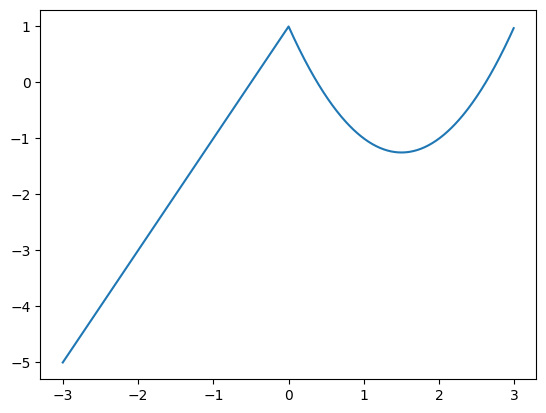

In [4]:
def f(x):
    ret = np.NaN
    if x < 0:
        ret = 2*x+1
    else:
        ret = x**2-3*x+1
    return ret
x = np.arange(-3,3,0.01)
y = np.array([f(xs) for xs in x])
plt.plot(x,y);

<b>Note</b>, the continuity is an important factor, meaning functions such as the following are not allowed for being discontinuous!

$$f(x) = \begin{cases} 2x+1 & \textrm{If } x < 0\\
x^2-3x+2 & \textrm{ If } x \geq 0
\end{cases}$$

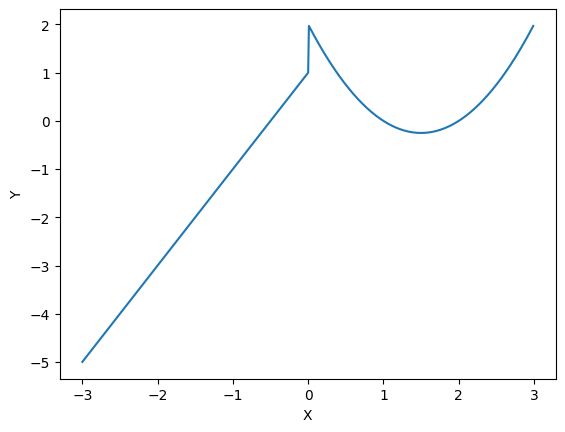

In [5]:
def f(x):
    ret = np.NaN
    if x < 0:
        ret = 2*x+1
    else:
        ret = x**2-3*x+2
    return ret
xs = np.arange(-3,3,0.01)
y = np.array([f(x) for x in xs])
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(xs,y);

### Knots
A point where a spline changes from one polynomial to another are called knots. 

For instance, 

$$f(x) = \begin{cases} 2x^2-x-4 & \textrm{If } x < -1\\
x^2+2x & \textrm{If } -1 \leq x < 2\\
2x^2 - 2x+4 & \textrm{If } 2 \leq x\end{cases} $$

has knots has $-1$ and $2$.

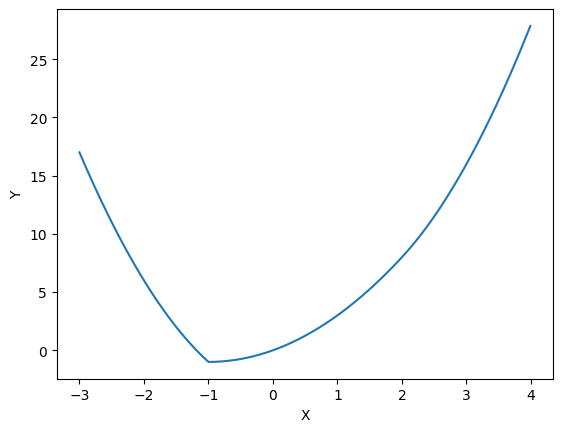

In [6]:
def f(x):
    ret = np.NaN
    if x < -1:
        ret = 2*x**2-x-4
    elif x < 2:
        ret = x**2 + 2*x #(x+1)**2-1
    else:
        ret = 2*x**2-2*x+4
    return ret
xs = np.arange(-3,4,0.01)
y = np.array([f(x) for x in xs])
plt.xlabel("X")
plt.ylabel("Y")
plt.plot(xs,y);

### Linear Splines

Let's start with linear splines. We use the $\color{blue}{\textit{ramp function}}$ (or RELU activation function)

$$(x)_{+} = \begin{cases} 0 & \textrm{If } x < 0\\
x &  \textrm{If } x \geq 0
\end{cases}$$

This is a spline with a knot at $0$. If we consider relationships of the form

$$y = \beta_0 + \beta_1 x + \beta_2 (x)_{+}$$

we get as a piecewise function

$$y = \begin{cases} \beta_0 + \beta_1 x & \textrm{If } x < 0\\
\beta_0 + (\beta_1 + \beta_2) x & \textrm{If } x \geq 0 \end{cases}$$

Following the key condition of continuity, this actually covers all linear splines with a knot at $0$.

### Implementation

We can implement the Ramp function in code using the ``maximum`` function (note not max) from the ``numpy`` module. 

In [7]:
ar = np.array([-2,-1,0,1,2])
np.maximum(0,ar)

array([0, 0, 0, 1, 2])

### Adding More Knots

How do we add more knots other than at $0$. To add a knot at $\tau$ we just need a term of the form

$$(x-\tau)_+ = \begin{cases} 0 & \text{If } x < \tau\\
x-\tau & \text{If } x \geq \tau\end{cases}$$

Note this is a continuous function which is equal to $0$ for $x < \tau$.

The formula for a linear spline with $k$ knots $\tau_1, \tau_2, \dots \tau_k$ is:
$$
y_{i}=\beta _{0}+\beta _{1}x_{i}+\beta _{2}(x_{i}-\tau _{1})_{+}+\dots +\beta _{K+1}(x_{i}-\tau _{K})_{+}+\epsilon _{i}
$$

In [8]:
#Generate data
xg = np.linspace(-2, 2, 10000)
yg_true = runge(xg)
X = xg.reshape(-1,1)

In [9]:
#Get knots -2,-1.5,-1,...,1.5,2
knots = np.arange(-2,2.5,0.5)
features = [X]
for k in knots:
    features.append(np.maximum(0,X-k))
#Design matrix
d_matrix = np.hstack(features)

In [10]:
#Fit the regression line on the spline features
reg = LinearRegression()
reg.fit(d_matrix,yg_true)
reg.coef_

array([ 2.85779185e+10, -2.85779185e+10,  6.25685147e-02, -3.54672601e-02,
        1.68840559e+00, -3.43902227e+00,  1.68839790e+00, -3.54621943e-02,
        6.25391486e-02,  0.00000000e+00])

In [11]:
#Do the same transformation on the axis so we can plot it.
axis = np.arange(-2,2,0.01).reshape(-1,1)
features = [axis]
for k in knots:
    features.append(np.maximum(0,axis-k))
axis_matrix = np.hstack(features)
axis_matrix

array([[-2.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [-1.99,  0.01,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [-1.98,  0.02,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 1.97,  3.97,  3.47, ...,  0.97,  0.47,  0.  ],
       [ 1.98,  3.98,  3.48, ...,  0.98,  0.48,  0.  ],
       [ 1.99,  3.99,  3.49, ...,  0.99,  0.49,  0.  ]])

In [ ]:
#Plot the data
plt.scatter(xg,yg_true)
plt.plot(axis,reg.predict(axis_matrix),color="red")
plt.xlabel("x")
plt.ylabel("y")
plt.title("OLS regression using Linear Splines")
plt.show()

We can see this fits the shape of the function much better that the polynomial regression. It's really only off at around 0.5. 

<img src="images/runge-w-linear-spline.png" alt="piecewise-spline" width="100%">

### Linear Spline with 3 internal knots

The formula for a linear spline with $3$ knots $\tau_1, \tau_2, \tau_3$ is:
$$
y_{i}=\beta _{0}+\beta _{1}x_{i}+\beta _{2}(x_{i}-\tau _{1})_{+}+\beta _{3}(x_{i}-\tau _{3})_{+}+\beta _{4}(x_{i}-\tau _{3})_{+}+\epsilon _{i}
$$
where for each $i \in (1,2,3)$,
$$(x-\tau_{i})_+ = \begin{cases} 0 & \text{If } x < \tau_{i}\\
x-\tau_{i} & \text{If } x \geq \tau_{i}\end{cases}$$

### Linear Spline with 3 internal knots

Fully expanded piecewise form:

$$
s(x) =
\begin{cases}
\beta_0 + \beta_1 x,
& x \le \xi_1, \\[6pt]

\beta_0 + \beta_1 x
+ \beta_2 (x - \xi_1),
& \xi_1 < x \le \xi_2, \\[6pt]

\beta_0 + \beta_1 x
+ \beta_2 (x - \xi_1)
+ \beta_3 (x - \xi_2),
& \xi_2 < x \le \xi_3, \\[6pt]

\beta_0 + \beta_1 x
+ \beta_2 (x - \xi_1)
+ \beta_3 (x - \xi_2)
+ \beta_4 (x - \xi_3),
& x > \xi_3 .
\end{cases}
$$

Linear splines are often called <b>``broken-stick"</b> models.

### Linear Spline with 3 internal knots

Taking derivatives interval by interval: <i>specifically, the slope of the spline is</i>

$$
s'(x) =
\begin{cases}
\beta_1,
& x \le \xi_1, \\[6pt]

\beta_1 + \beta_2,
& \xi_1 < x \le \xi_2, \\[6pt]

\beta_1 + \beta_2 + \beta_3,
& \xi_2 < x \le \xi_3, \\[6pt]

\beta_1 + \beta_2 + \beta_3 + \beta_4,
& x > \xi_3 .
\end{cases}
$$

The derivative is a piecewise-constant within each interval.

### Linear Spline with 3 internal knots

<div style="display: flex; gap: 2px;">
  <div style="flex: 1;">
   <img src="images/piecewise-linear-spline.png" alt="piecewise-spline" width="100%">
  </div>
  <div style="flex: 1;">
    <img src="images/piecewise-linear-spline-gradient.png" alt="piecewise-gradient"  width="100%">
  </div>
</div>


### Choosing Knot Placement

- If you have an idea of how many knots there should be you could do hyperparameter tuning to determine their location.
- Regression Splines are most flexible in regions that have a lot of knots as the coefficients can change rapidly. Hence one strategy is to place more knots in places where the function might vary most rapidly, and fewer where the function is relatively stable.
- We can also place knots at uniform quantiles across the domain. We can do this programmatically by specifying the number of knots or degrees of freedom (df) of the overall model space.<br> 
If each piece of the spline is a polynomial of degree $d$, the number of knots would be $\color{blue}{{df-d}}$ (without intercept in the overall spline function space) $\rightarrow \color{blue}{\textbf{Proof Optional!}}$

### Choosing Knots

If there are "obvious" changes in behavior in a dataset you might choose knots manually. However, this generally isn't the best approach.
Instead what's better is using "too many" knots and then applying a penalty to prevent the model from getting "too complicated".

#### Specifying Knots in Implementation

We can use a set of splines called basis splines or B-splines by importing the `BSplines` module from `statsmodels.gam.api` package. Intuitively speaking, any spline curve you want (with given degree and knots) can be built by adding together these B-spline shapes with the right weights (<i>analogous to the basis of a vector space</i>).

Here we use B-splines to create terms for regression models and fit some non-linear data. The number of knots is provided by specifying the polynomial degree (3 because we use <b>Cubic Basis Splines</b>) and the degrees of freedom (8).

Once the design matrix has been built with spline features, we use Ordinary Least Squares to fit the resulting model.

In [13]:
np.random.seed(0)

# Toy nonlinear data
n = 200
x = np.sort(np.random.uniform(0, 10, size=n))
y_true = np.sin(x) + 0.2 * x
y = y_true + np.random.normal(0, 0.4, size=n)

# Build B-spline basis
# df : number of basis functions (roughly "flexibility")
# degree : spline polynomial degree (3 = cubic)
x2d = x.reshape(-1, 1)
bs = BSplines(x2d, df=[8], degree=[3])

# The spline basis matrix (n x df)
B = bs.basis  # design matrix of spline features

# Optional: add an intercept explicitly
X = sm.add_constant(B, has_constant="add")

# Fit OLS on the spline basis
model = sm.OLS(y, X).fit()
# print(model.summary())


In [ ]:
# Predict on a grid for plotting
xg = np.linspace(x.min(), x.max(), 400)
# build basis and generate spline features on grid
bs_g = BSplines(xg[:, None], df=[8], degree=[3])
Bg = bs_g.basis
Xg = sm.add_constant(Bg, has_constant="add")
yhat = model.predict(Xg)

# Plot the data
plt.figure(figsize=(9, 4.8))
plt.scatter(x, y, s=18, label="data")
plt.plot(x, y_true, linewidth=2, label="true")
plt.plot(xg, yhat, linewidth=2, label="B-spline OLS fit")
plt.xlabel("x")
plt.ylabel("y")
plt.title("OLS regression using B-splines")
plt.legend()
# plt.show()

<img src="images/ols-bspline.png" alt="OLS regression using B-Splines" scale="0.75;" style="width: 90%;">

### Higher Degree Splines

Much like in the previous demonstration, we often want non-linearity in our piecewise polynomials. Hence we look beyond linear splines.

This can be accomplished by just taking higher powers of our ramp function. For instance solving the least squares solution to the equation below would result in a quadratic spline with a knot at $2$.

$$y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3(x-2)_{+}+\beta_4(x-2)_{+}^2$$

For the most part, cubic splines suffice and are commonly used in practice.

### Natural Splines

Splines can exhibit high variance towards the outer ranges of the predictor value: that is closer to the minimum and maximum values of $\textrm{x}$. At the edges, a spline is allowed to bend arbitrarily.<br>
To fix this, we impose <u>additional boundary constraints</u> on the spline.

$\color{blue}{\textbf{Natural Spline}}$: a regression spline where the function is required to be <i>linear</i> at the boundaries, i.e., in the regions where $\textrm{x}$ is smaller than the smallest knot, or larger than the largest knot. For natural cubic splines, this ensures curvature ($2^{nd}$ order derivative) at boundaries is zero. 
Natural Splines generally produce more stable estimates at the boundary.

<img src="images/natural-v-standard-spline-boundary.png" alt="Natural Splines" scale="0.75;" style="width: 70%;">

### Smoothness of Splines

Recall this spline from earlier, with knots at $-1$ and $2$. Note how you can't even really tell from the graph where the 2nd knot is. This because the function $x^2+2x$ and $2x^2-2x+4$ have the same derivatives at the knot $x=2$.<br> 
$\color{blue}{\textbf{This is a key continuity principle!}}$

Smoothness requires polynomials of degree $d$, adjacent to each other at a knot, to have same value ($0$-th derivative) as well as the same value of derivatives of degree $1, 2, \dots d-1$.

For cubic spline, at knot $\tau_i$, this means:
$$
P_i(\tau_i) = P_{i+1}(\tau_i),  
P'_i(\tau_i) = P'_{i+1}(\tau_i), 
P''_i(\tau_i) = P''_{i+1}(\tau_i)
$$
<i>Continuity is not imposed on third derivative as doing so will over-constrain the model!</i> $\rightarrow \color{blue}{\textbf{Why?}}$

### Types of Splines
<p>Typically when used splines are broke up into one of the following cases.</p>

- <b>Linear Splines</b> or $C^0$, (Sometimes called elbow regression) where all components are linear.
  
- <b>Quadratic Splines</b> or $C^1$, will be continuous at 1st derivatives, they'll have basis
  $$
  y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 (x-k_1)_{+}^2 + \beta_4 (x-k_2)_{+}^2 + \ldots + \beta_{2+n}(x-k_n)_{+}^2
  $$
  
- <b>Cubic Splines</b> or $C^2$, or smooth splines, will be continuous at 1st and 2nd derivatives and have basis
  $$
  y = \beta_0 + \beta_1 x + \beta_2 x^2 + \beta_3 x^3 +  \beta_4(x-k_1)_{+}^3 + \beta_5 (x-k_2)_{+}^3 + \ldots + \beta_{3+n}(x-k_n)_{+}^3
  $$

<img src="images/spline-continuity-degrees-comparison.png" alt="Runge Phenomenon Polynomial Fit" scale="0.75;" style="width: 90%;">

### Higher Dimensional Splines

We've been talking about splines only in the context of single variable regression. However, they can be used in multivariate contexts as well.<br>
Typically though the basis will be much more complicated, containing terms like 
$$1,x_1,x_2,(x_2-(x_1+x_2))_{+},(x_1-(x_1+x_2))_{+}$$

Instead of intervals, the splines will usually stick with a definition on "triangles" called a simplex.

## Splines in practice

``Sklearn`` has a built in tool called ``SplineTransformer`` for transforming data into spline regression. However, for numerical reasons they don't use the basis we use above. Instead, they also use $B$-splines, where each basis is nonzero on only a fixed area.

For instance, instead of finding coefficients for $1,x$ and $(x)_{+}$ you can find coefficients for $B_1(x) = 1-x, B_2(x) = x-(x)_{+}$, and $B_3=(x)_{+}$.

There's two ways to specify knots. You can either choose uniform or quantile. Uniform makes them equally spaced where as quantile tries to make each interval contain the same number of data points. By default the specification is `uniform`.

Another thing to note is that by default the min $\textrm{x}$ value and max $\textrm{x}$ value are considered knots.

Let's use this module to fix the previously demonstrated runge phenomenon using cubic splines.

In [ ]:
from sklearn.preprocessing import SplineTransformer

#Generate data
xg = np.linspace(-2, 2, 10000)
yg_true = runge(xg)
X = xg.reshape(-1,1)

# Using cubic splines to fit data
spl_t = SplineTransformer(degree=3,n_knots=21)
spl_X = spl_t.fit_transform(X)
reg = LinearRegression()
reg.fit(spl_X,yg_true)

#Interpolate using spline regression on a grid
ax = np.arange(-2,2,0.01).reshape(-1,1)
plt.scatter(X,yg_true, label="data")
plt.plot(ax,reg.predict(spl_t.transform(ax)),color="Red",label="Cubic Basis Spline")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Cubic Basis Splines to fit Runge Phenomenon")
plt.legend()
plt.show()

<img src="images/cubic-bspline-runge.png" alt="Runge Phenomenon Fit w Cubic Basis Splines" scale="0.75;" style="width: 90%;">

### Thats all folks!

<h4><b>For now...</b></h4>

<div style="text-align: center;">
    <img src="images/end-slide.jpg" alt="Spline Regression The End" scale="0.01;" style="width: 40%;">
</div>